In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!git clone https://github.com/THU-MIG/yolov10.git
%cd yolov10

# Step 1: Manually edit requirements.txt to prevent it from installing conflicting packages.
# We use 'sed' to comment out the lines for torch, torchvision, and pytorch-lightning.
!sed -i -e 's/^torch==.*/#&/' -e 's/^torchvision==.*/#&/' -e 's/^pytorch-lightning==.*/#&/' requirements.txt

# Step 2: Now, install from the modified requirements file. This will skip the problematic packages.
!pip install -r requirements.txt -q

# Step 3: Install the correct, compatible versions of the libraries we skipped earlier.
!pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 pytorch-lightning==2.2.1 -q

# Step 4: Uninstall wandb and ray, which are not needed and cause issues in Kaggle.
!pip uninstall -y wandb ray -q

# Step 5: Install the yolov10 package itself in editable mode.
!pip install -e . -q

import os
import yaml
import torch
import subprocess

Cloning into 'yolov10'...
remote: Enumerating objects: 20338, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 20338 (delta 2), reused 0 (delta 0), pack-reused 20334 (from 2)
Receiving objects: 100% (20338/20338), 11.10 MiB | 21.86 MiB/s, done.
Resolving deltas: 100% (14354/14354), done.
/kaggle/working/yolov10/yolov10
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ultralytics (pyproject.toml) ... done


In [3]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using device:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA not available, using CPU. This will be very slow.")

PyTorch version: 2.1.0+cu121
CUDA available: True
Using device: Tesla T4


In [4]:
# Define the path to the dataset on Kaggle
dataset_base_path = '/kaggle/input/medical-image-dataset-brain-tumor-detection/BrainTumor/BrainTumorYolov8'

# Create the data configuration dictionary with 3 classes
data_config = {
    'train': os.path.join(dataset_base_path, 'train/images'),
    'val': os.path.join(dataset_base_path, 'valid/images'),
    'test': os.path.join(dataset_base_path, 'test/images'),
    'nc': 3,
    'names': ['glioma', 'meningioma', 'pituitary']
}

# Write the dictionary to a YAML file
# The official training script looks for it in 'ultralytics/cfg/datasets'
config_dir = 'ultralytics/cfg/datasets'
os.makedirs(config_dir, exist_ok=True)
config_path = os.path.join(config_dir, 'brain_tumor_data.yaml')

with open(config_path, 'w') as f:
    yaml.dump(data_config, f, default_flow_style=False)

print("Dataset configuration file created at:", config_path)
with open(config_path, 'r') as f:
    print("\nYAML file content:\n---")
    print(f.read())
    print("---")


Dataset configuration file created at: ultralytics/cfg/datasets/brain_tumor_data.yaml

YAML file content:
---
names:
- glioma
- meningioma
- pituitary
nc: 3
test: /kaggle/input/medical-image-dataset-brain-tumor-detection/BrainTumor/BrainTumorYolov8/test/images
train: /kaggle/input/medical-image-dataset-brain-tumor-detection/BrainTumor/BrainTumorYolov8/train/images
val: /kaggle/input/medical-image-dataset-brain-tumor-detection/BrainTumor/BrainTumorYolov8/valid/images

---


In [5]:
!wget https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt -q

In [6]:
print("\nStarting YOLOv10 training using the official repository...")
# The training script will show progress and time remaining for each epoch.
train_command = [
    'yolo', 'detect', 'train',
    f'data={config_path}',
    'model=yolov10n.pt',
    'epochs=20',
    'batch=-1', # Auto-batch size
    'imgsz=640',
    'device=0',
    'project=yolov10_training',
    'name=brain_tumor_baseline_3class'
]

# Using subprocess to run the command and see live output
process = subprocess.Popen(train_command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
for line in iter(process.stdout.readline, ''):
    print(line, end='')
process.stdout.close()
process.wait()


Starting YOLOv10 training using the official repository...
New https://pypi.org/project/ultralytics/8.3.189 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.11.13 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=ultralytics/cfg/datasets/brain_tumor_data.yaml, epochs=20, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=0, workers=8, project=yolov10_training, name=brain_tumor_baseline_3class, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buff

0

In [7]:
print("\nStarting YOLOv10 validation...")
best_model_path = 'yolov10_training/brain_tumor_baseline_3class/weights/best.pt'

val_command = [
    'yolo', 'detect', 'val',
    f'data={config_path}',
    f'model={best_model_path}',
    'imgsz=640',
    'split=test',
    'device=0'
]

# Run validation and capture output
result = subprocess.run(val_command, capture_output=True, text=True)
print(result.stdout)
print(result.stderr)

print("\nYOLOv10 training and validation complete.")
print(f"Find your results in the 'yolov10_training' directory.")

# Navigate back to the root directory for consistency in Kaggle
%cd ..



Starting YOLOv10 validation...
Ultralytics YOLOv8.1.34 🚀 Python-3.11.13 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 285 layers, 2695586 parameters, 0 gradients, 8.2 GFLOPs
val: WARNING ⚠️ Cache directory /kaggle/input/medical-image-dataset-brain-tumor-detection/BrainTumor/BrainTumorYolov8/test is not writeable, cache not saved.
                   all        308        308        0.8      0.796      0.856      0.614
                glioma        308        159       0.66      0.597      0.675       0.41
            meningioma        308         62      0.839      0.928      0.954      0.768
             pituitary        308         87        0.9      0.862      0.938      0.665
Speed: 1.2ms preprocess, 6.1ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /kaggle/working/yolov10/yolov10/runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


val: Scanning /kaggle/input/medical-image-dataset-brain-tumor-detection/BrainTumo

# 7 Display

--- Displaying results from the latest run: yolov10/yolov10_training/brain_tumor_baseline_3class ---

Training & Validation Metrics (Loss, mAP, etc.)


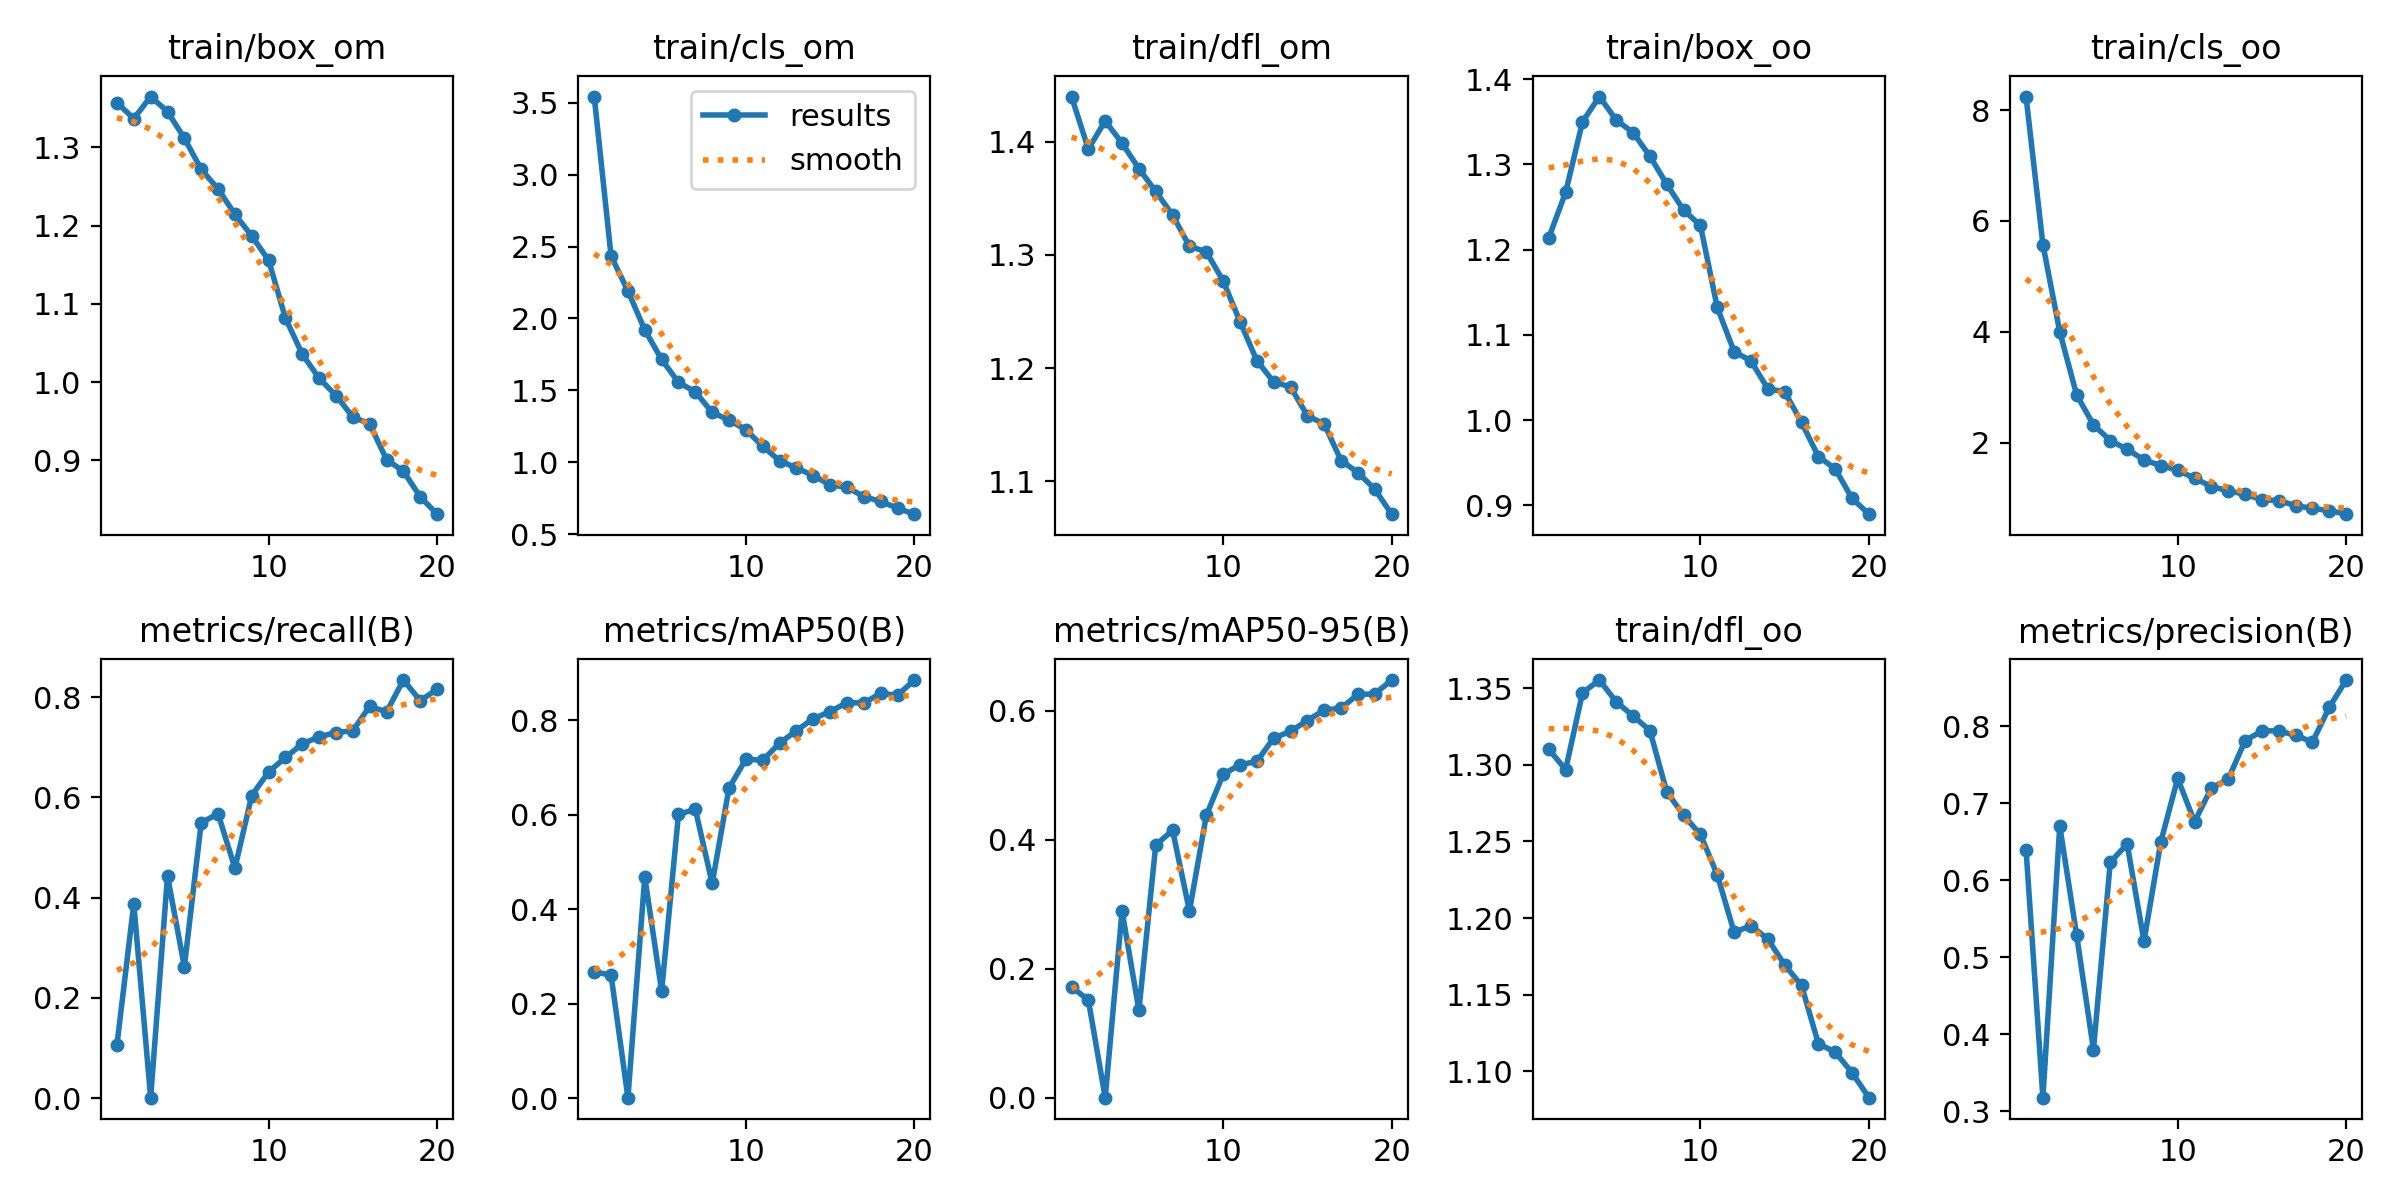

In [14]:

import os
import glob
from IPython.display import Image, display

try:
    results_dir_parent = 'yolov10/yolov10_training'
    # Get a list of all run directories and find the most recently modified one
    all_runs = [os.path.join(results_dir_parent, d) for d in os.listdir(results_dir_parent)]
    latest_run_dir = max(all_runs, key=os.path.getmtime)
    results_dir = latest_run_dir
    print(f"--- Displaying results from the latest run: {results_dir} ---")
except (FileNotFoundError, ValueError):
    print(f"Error: Could not find the directory '{results_dir_parent}'. Please ensure the training step has completed successfully.")
    results_dir = None

if results_dir:
    # 7.1 Training & Validation Metrics
    # Find and display the main results plot, which includes loss curves and mAP.
    results_plot_path = os.path.join(results_dir, 'results.png')
    if os.path.exists(results_plot_path):
        print("\nTraining & Validation Metrics (Loss, mAP, etc.)")
        display(Image(filename=results_plot_path, width=1500))
    else:
        print(f"Could not find results plot at: {results_plot_path}")



Confusion Matrix


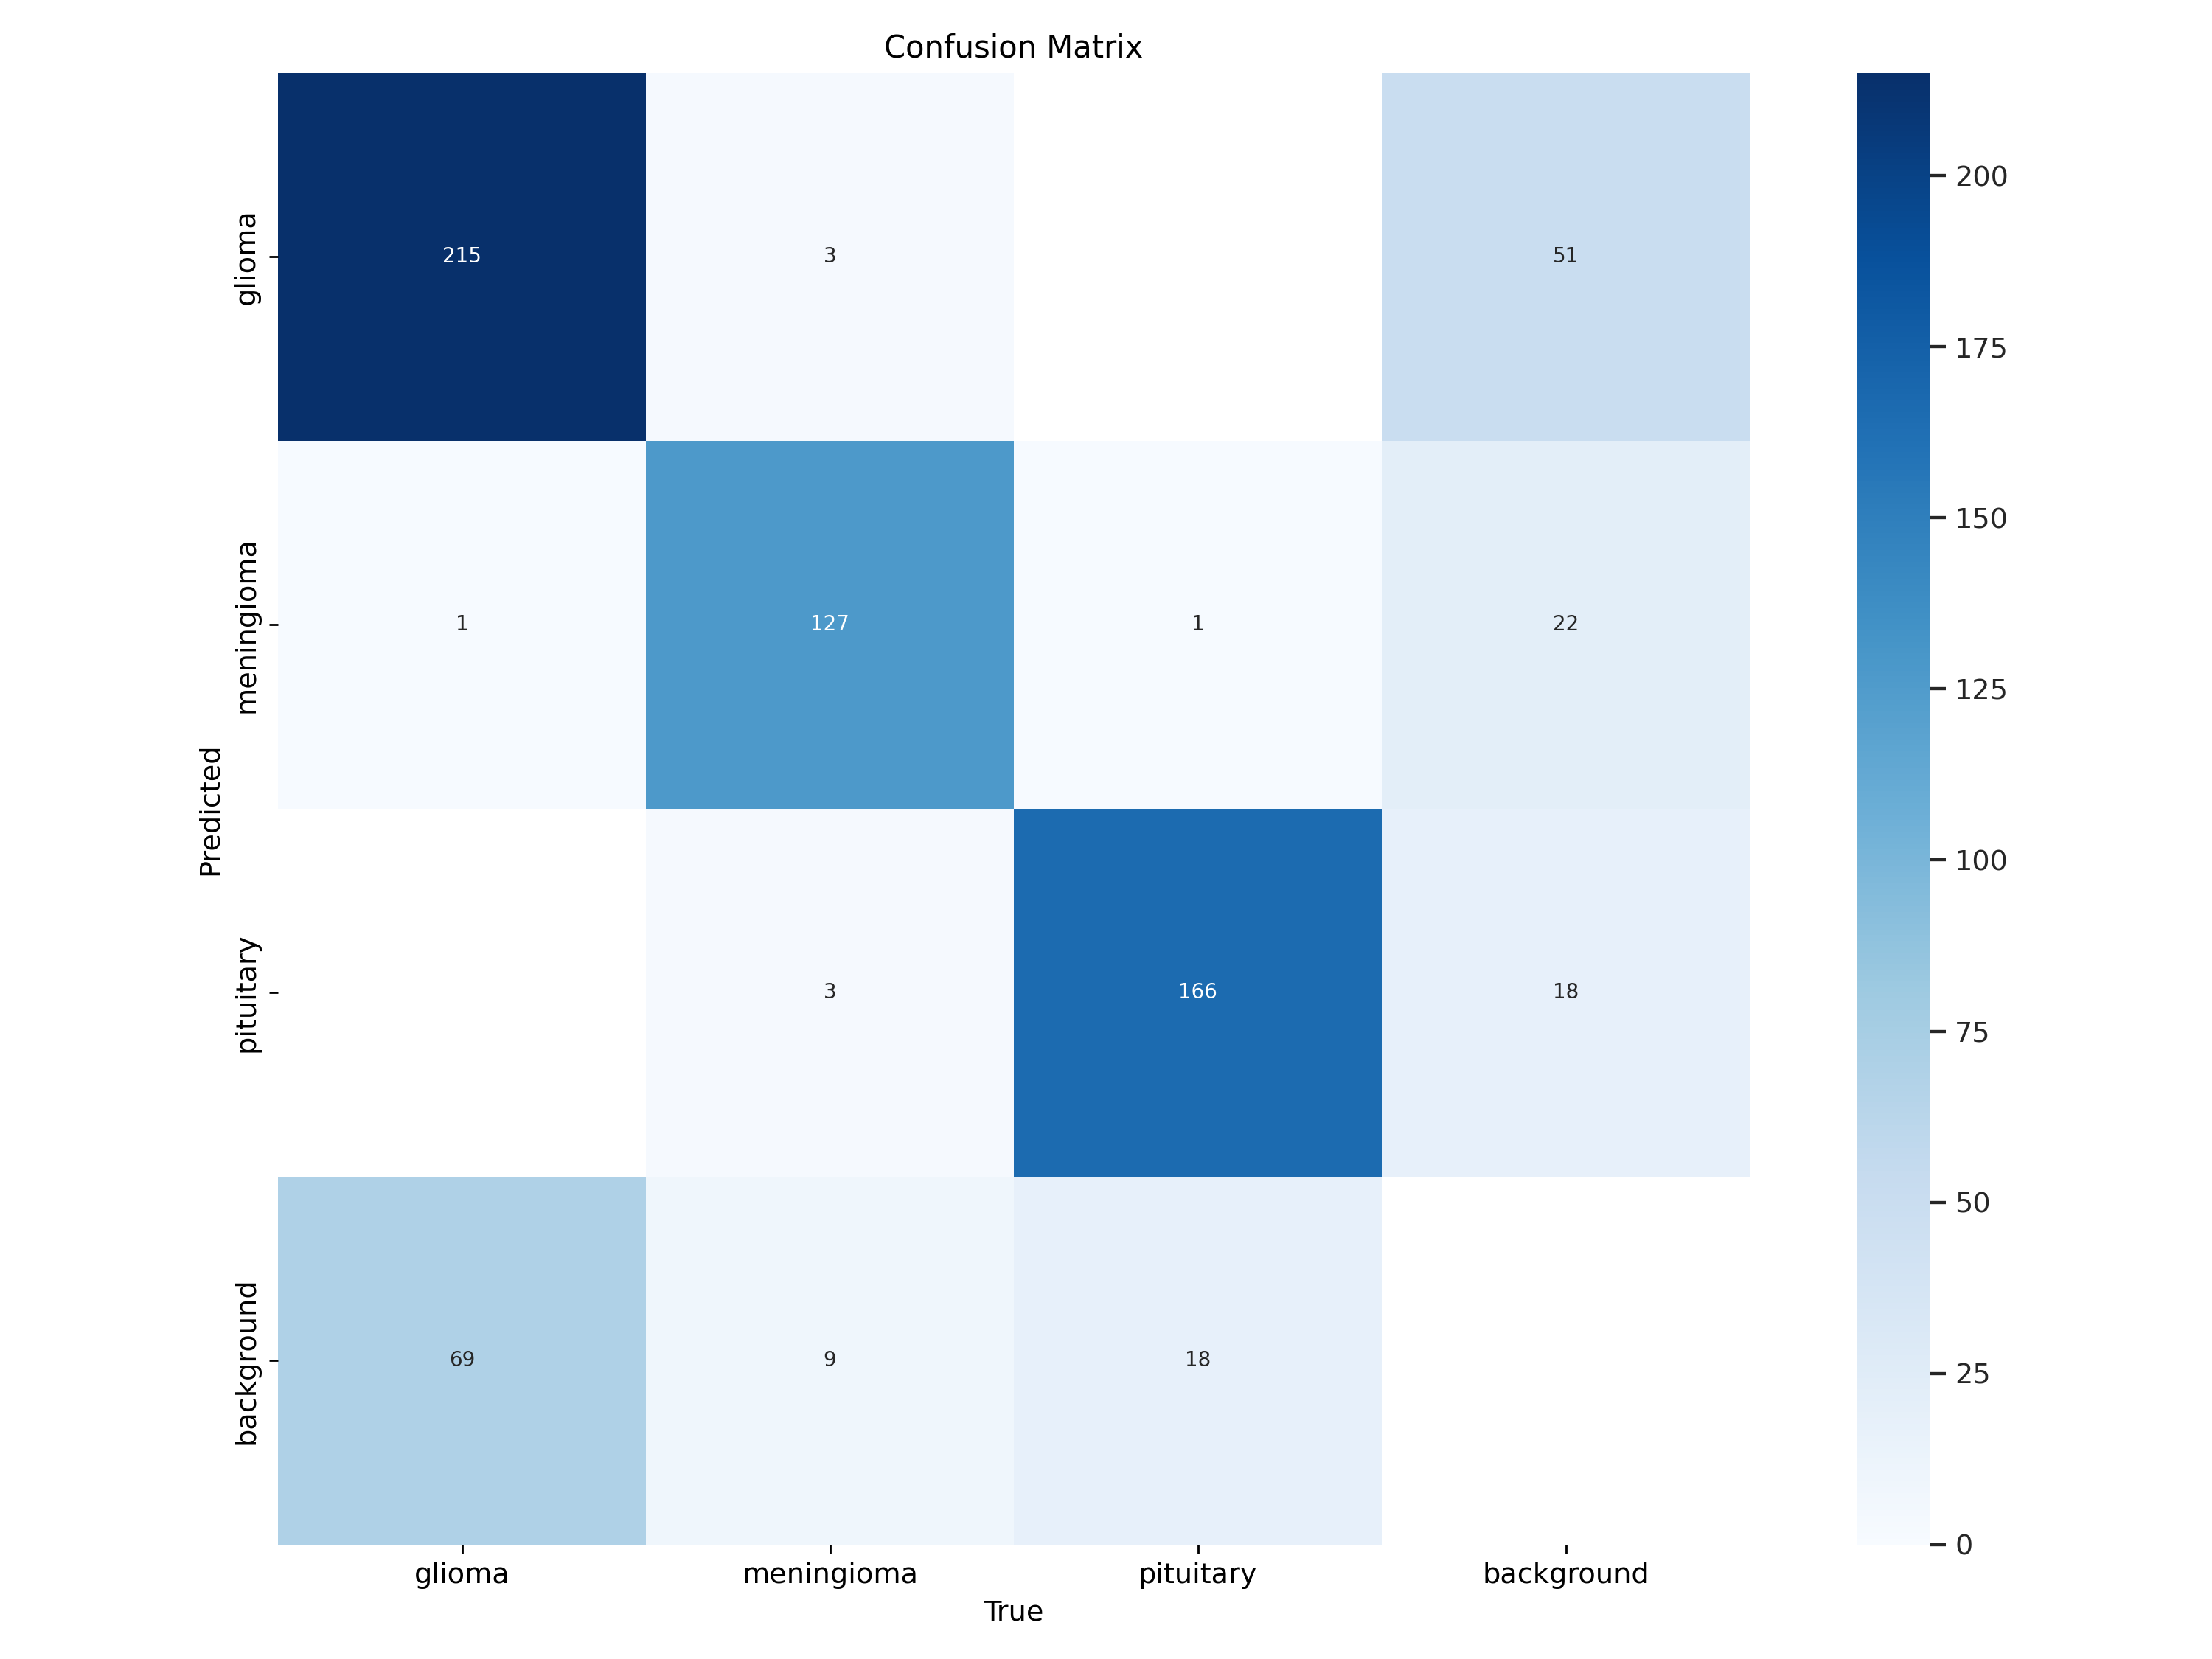

In [16]:

    # 7.2 Confusion Matrix
    # The confusion matrix is critical for error analysis. It shows what classes
    # the model is confusing with each other.
    confusion_matrix_path = os.path.join(results_dir, 'confusion_matrix.png')
    if os.path.exists(confusion_matrix_path):
        print("\nConfusion Matrix")
        display(Image(filename=confusion_matrix_path, width=1200))
    else:
        print(f"Could not find confusion matrix at: {confusion_matrix_path}")


Precision-Recall (PR) Curve


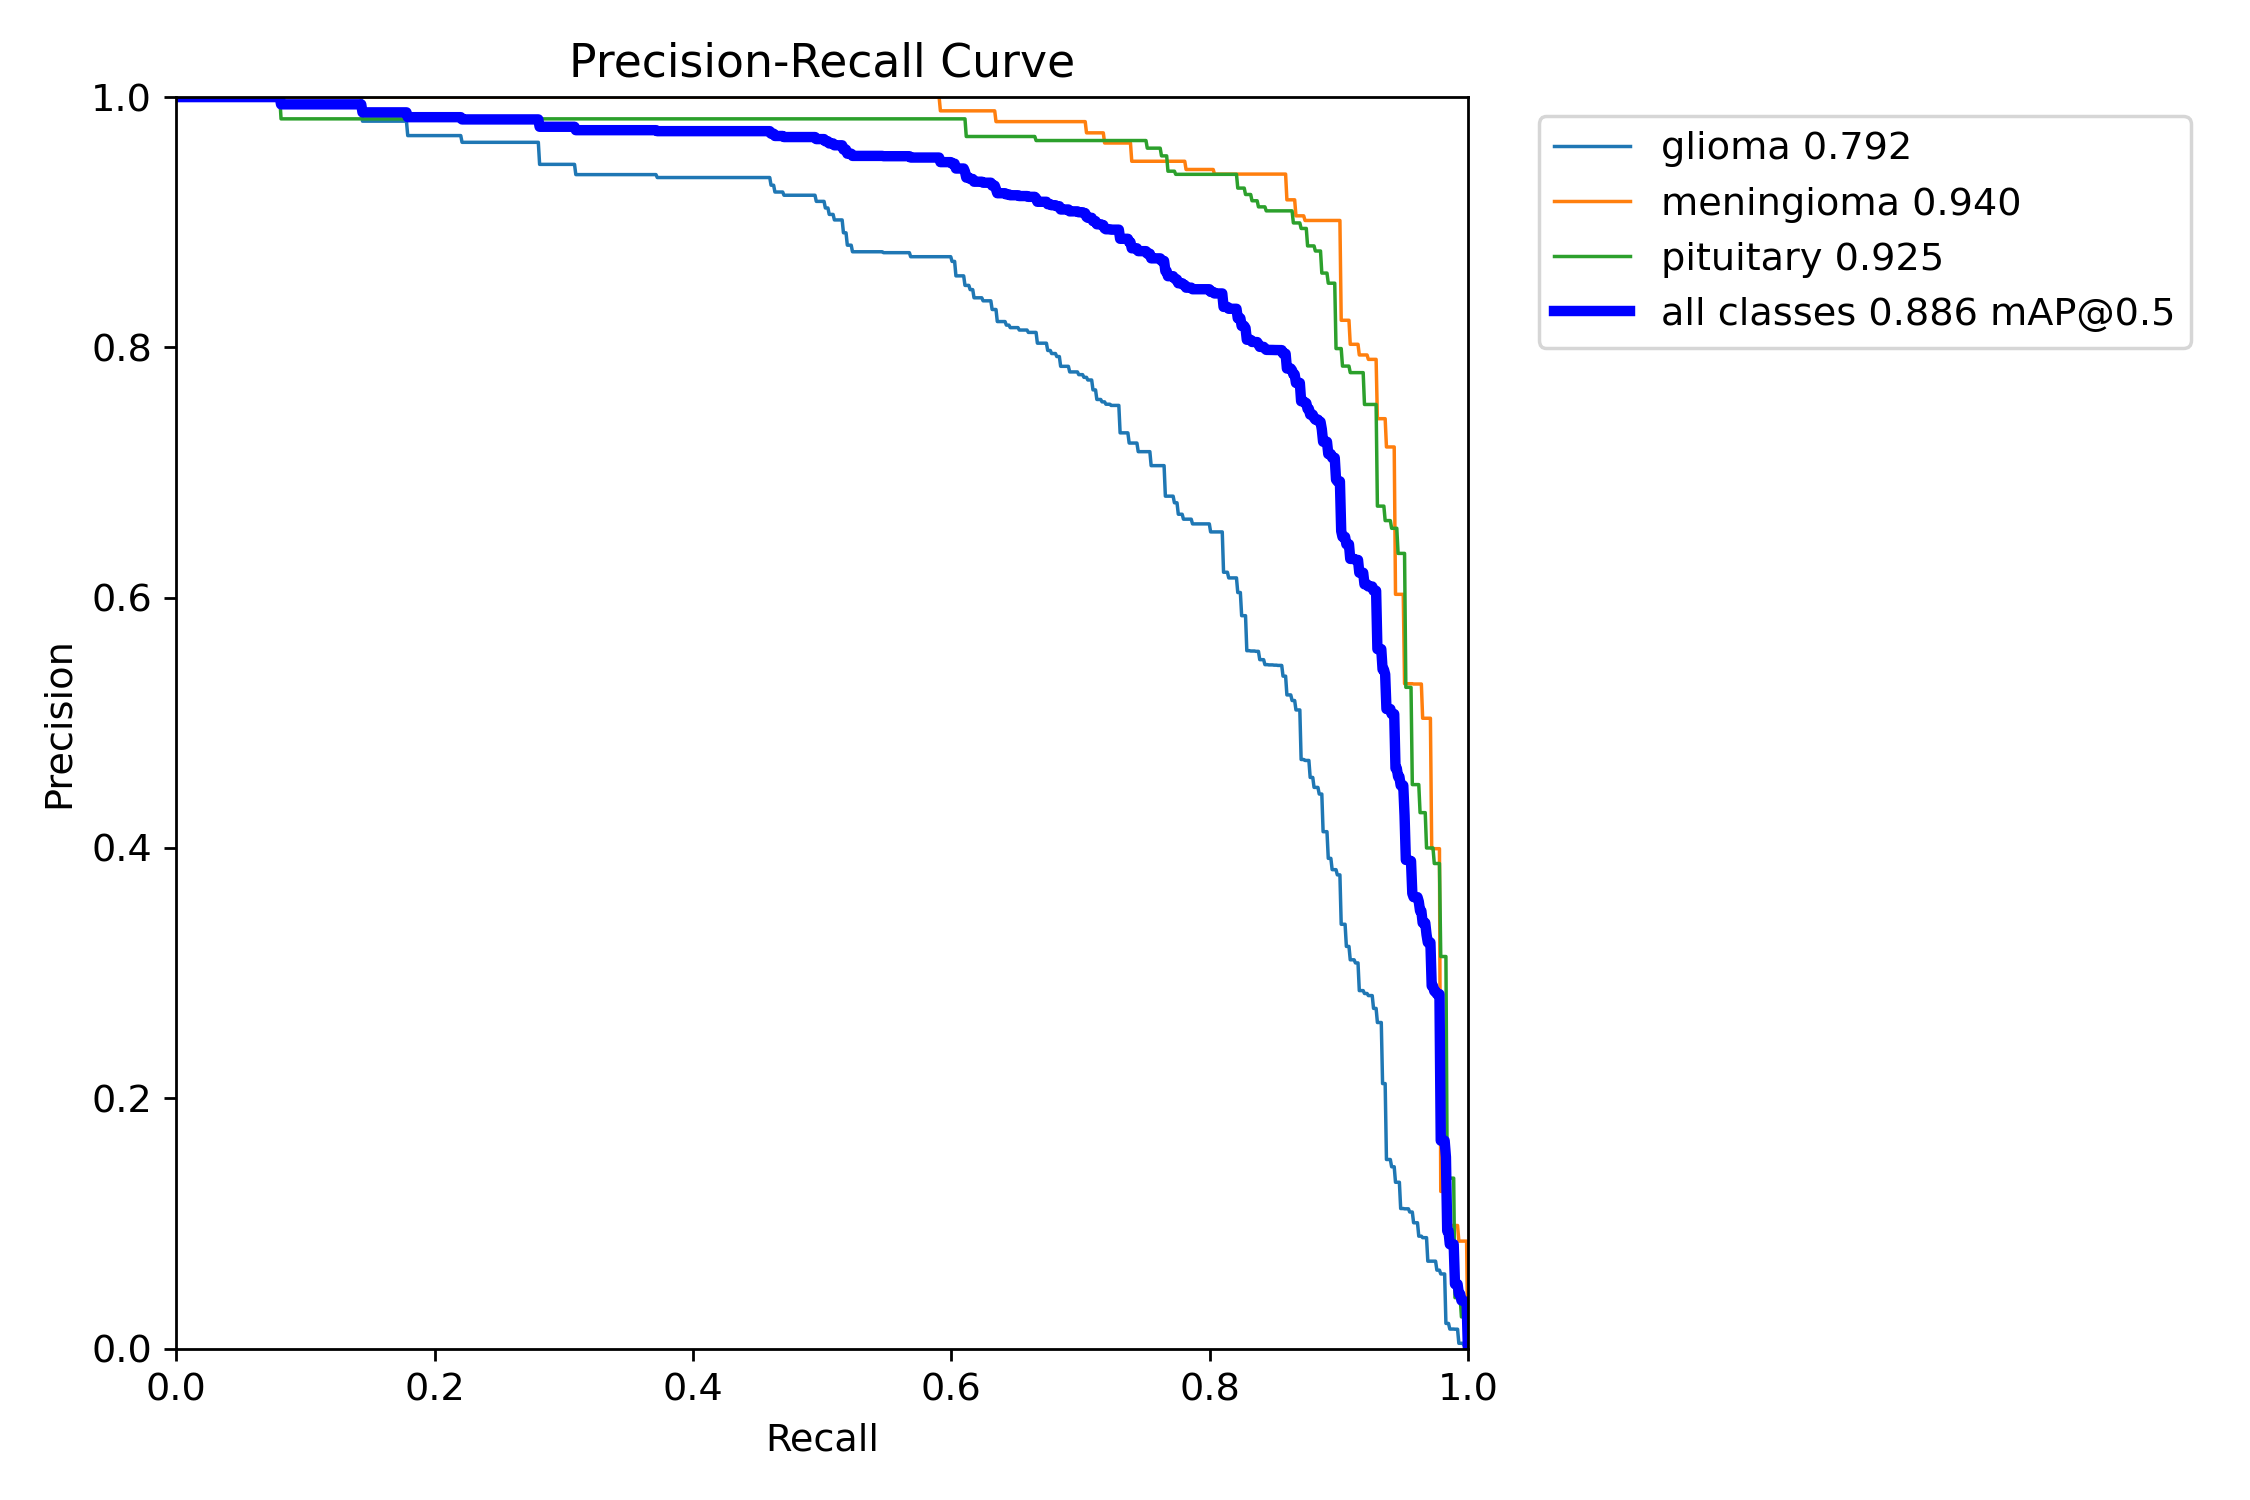

In [20]:

    # 7.3 Precision-Recall (PR) Curve
    # The PR curve is a key metric for object detection and is required by your project.
    pr_curve_path = os.path.join(results_dir, 'PR_curve.png')
    if os.path.exists(pr_curve_path):
        print("\nPrecision-Recall (PR) Curve")
        display(Image(filename=pr_curve_path, width=1200))
    else:
        print(f"Could not find PR curve at: {pr_curve_path}")


Qualitative Results (Predictions on Test Images)

Displaying: val_batch0_pred.jpg


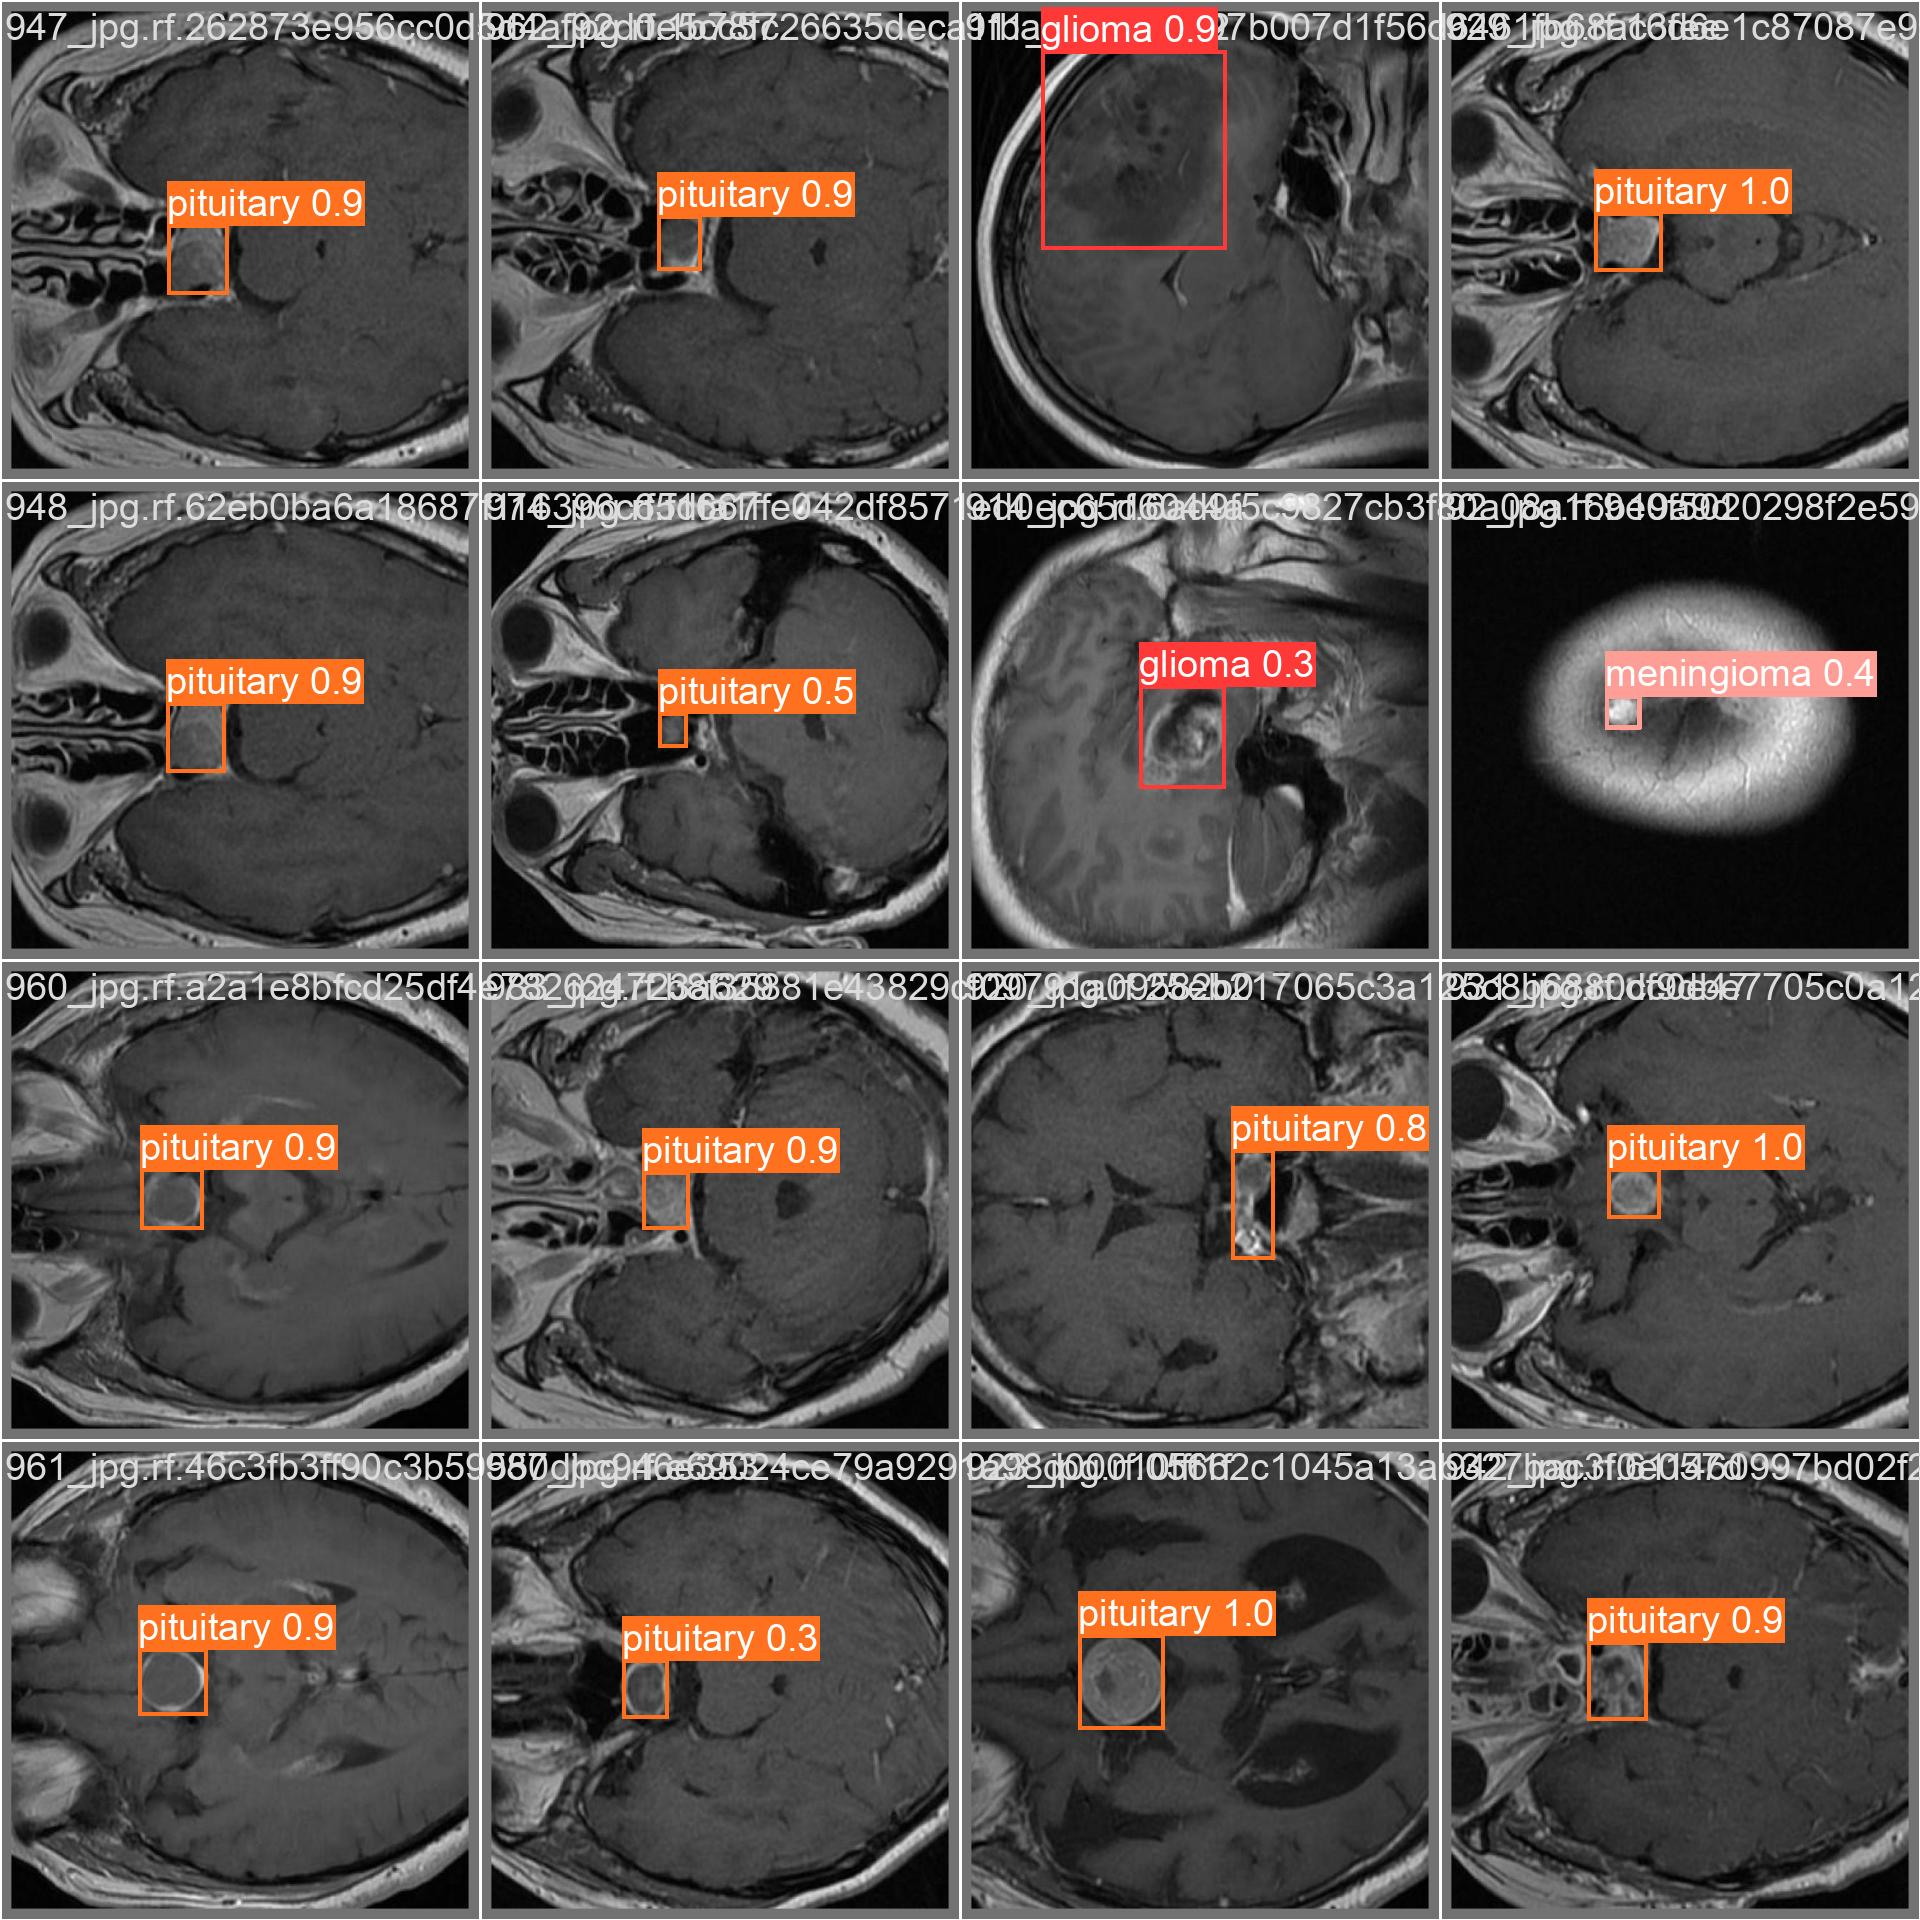


Displaying: val_batch1_pred.jpg


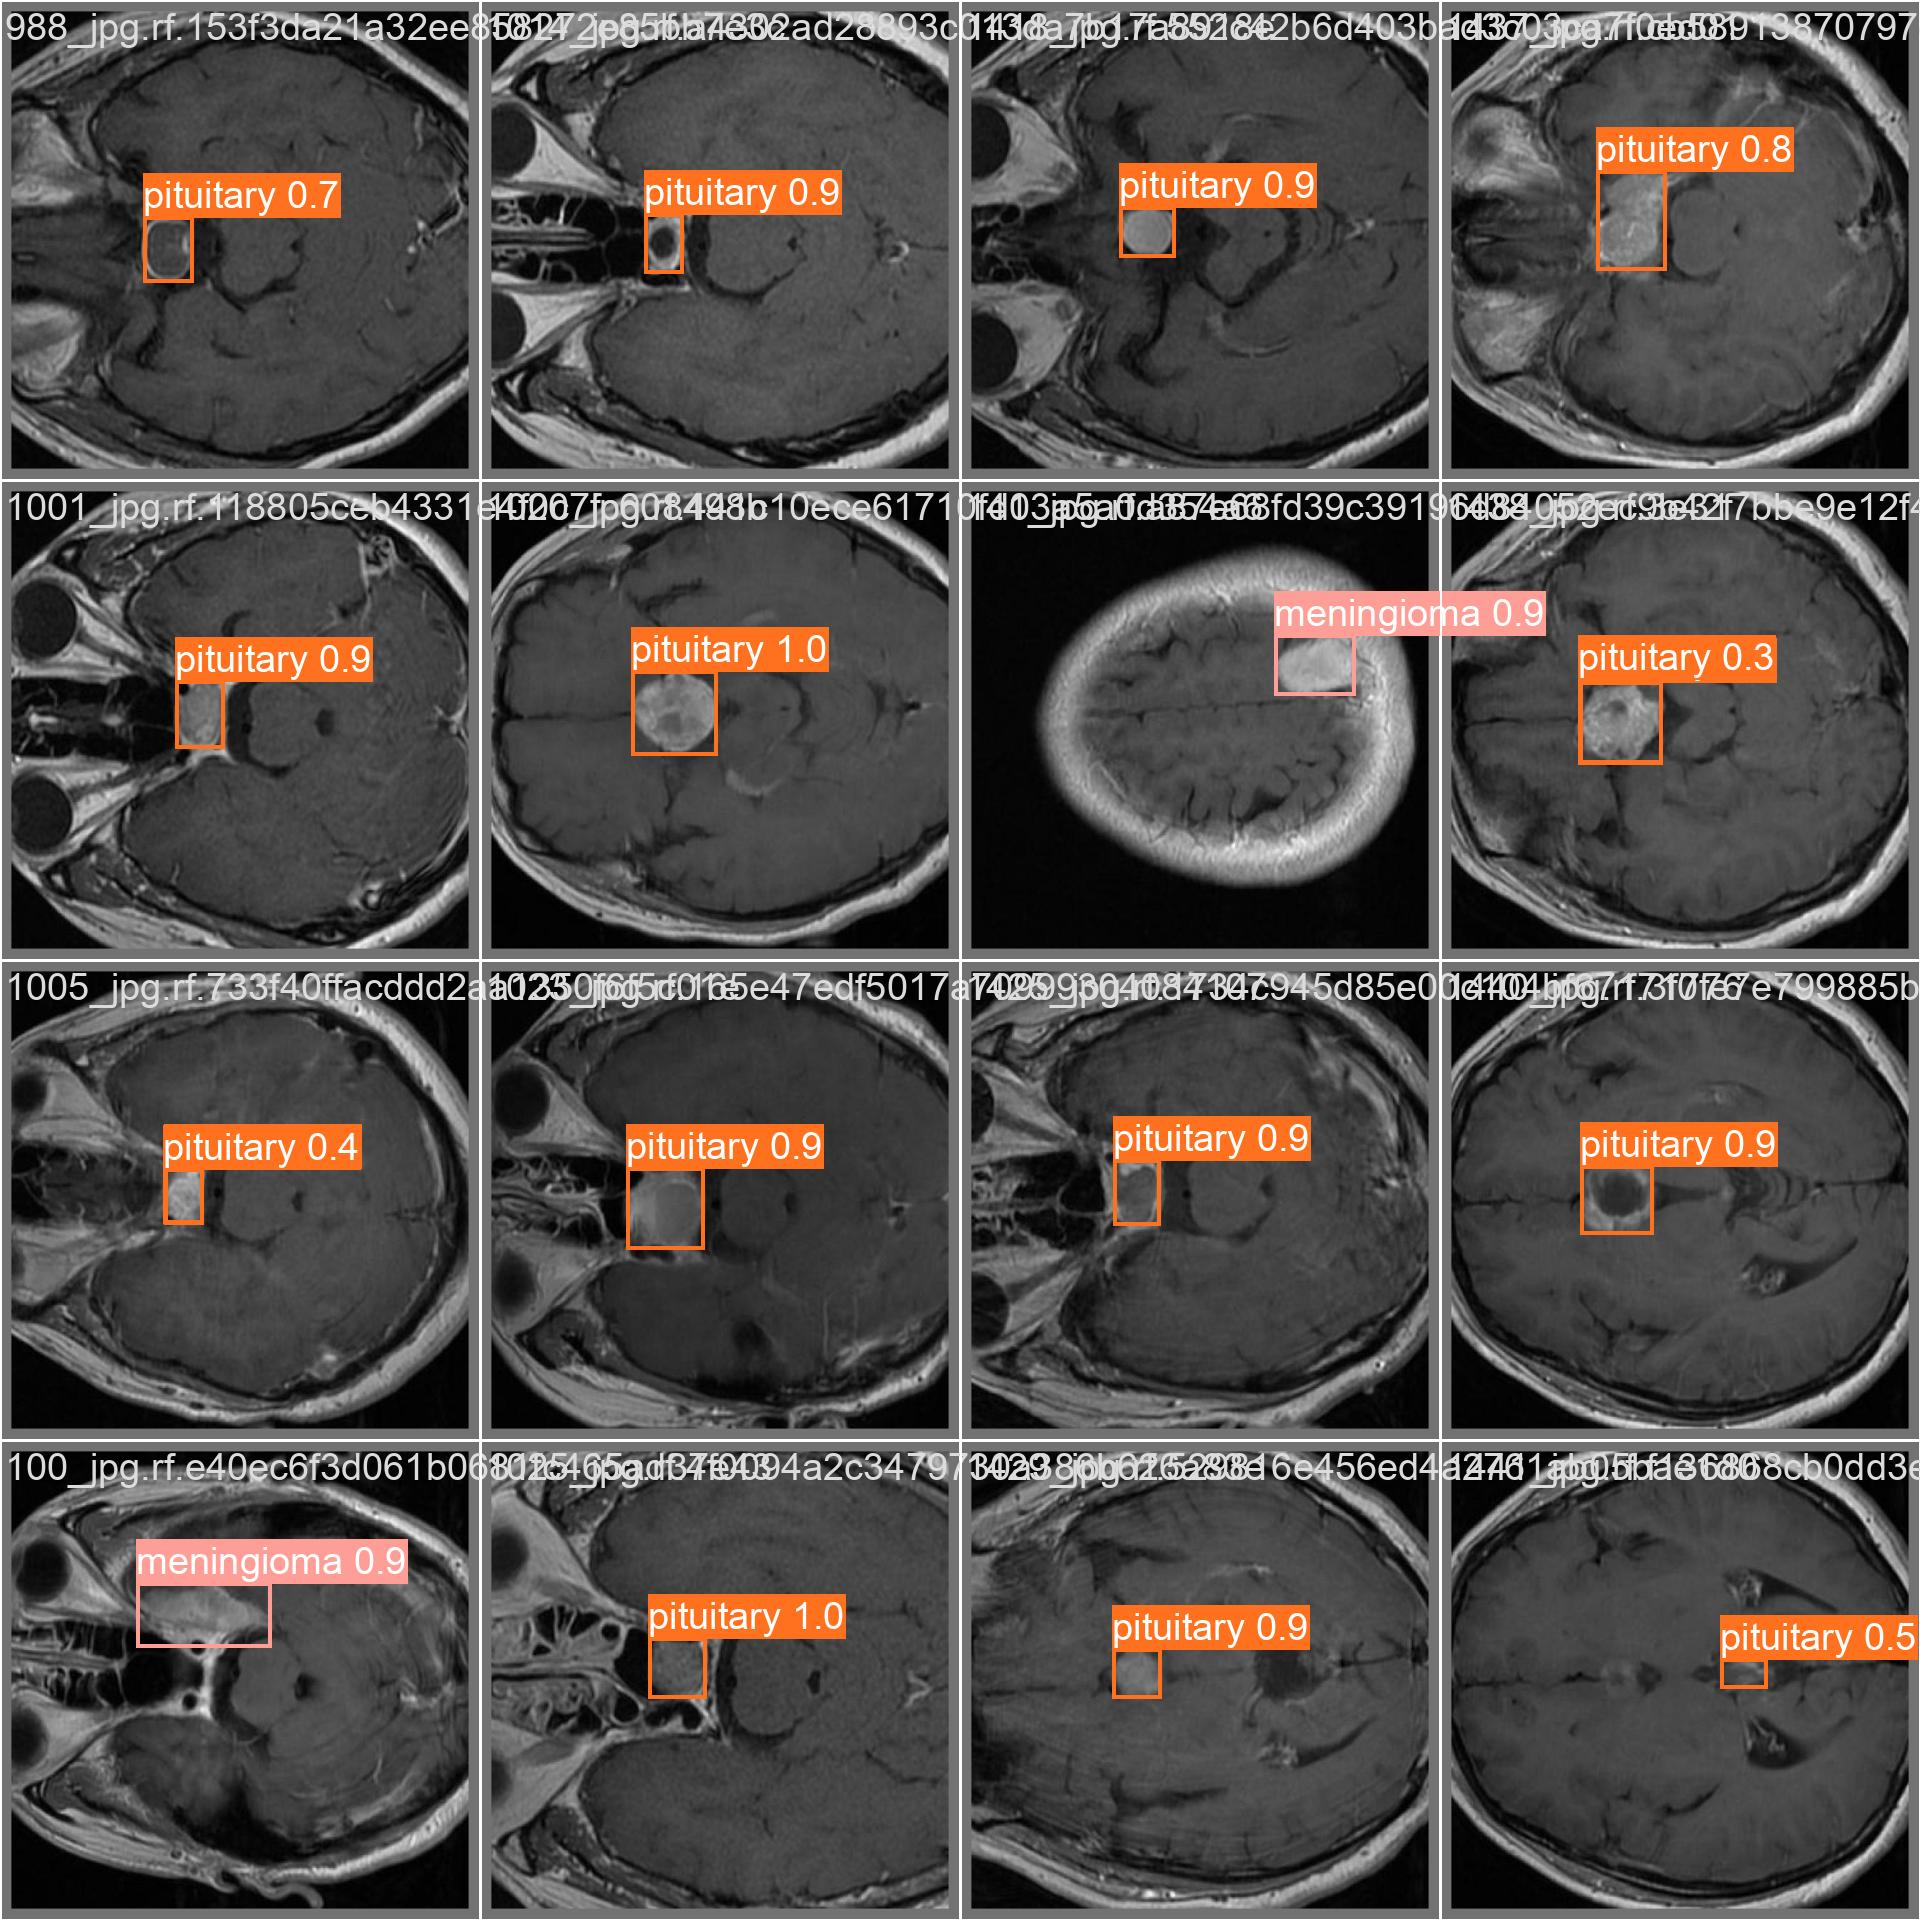


Displaying: val_batch2_pred.jpg


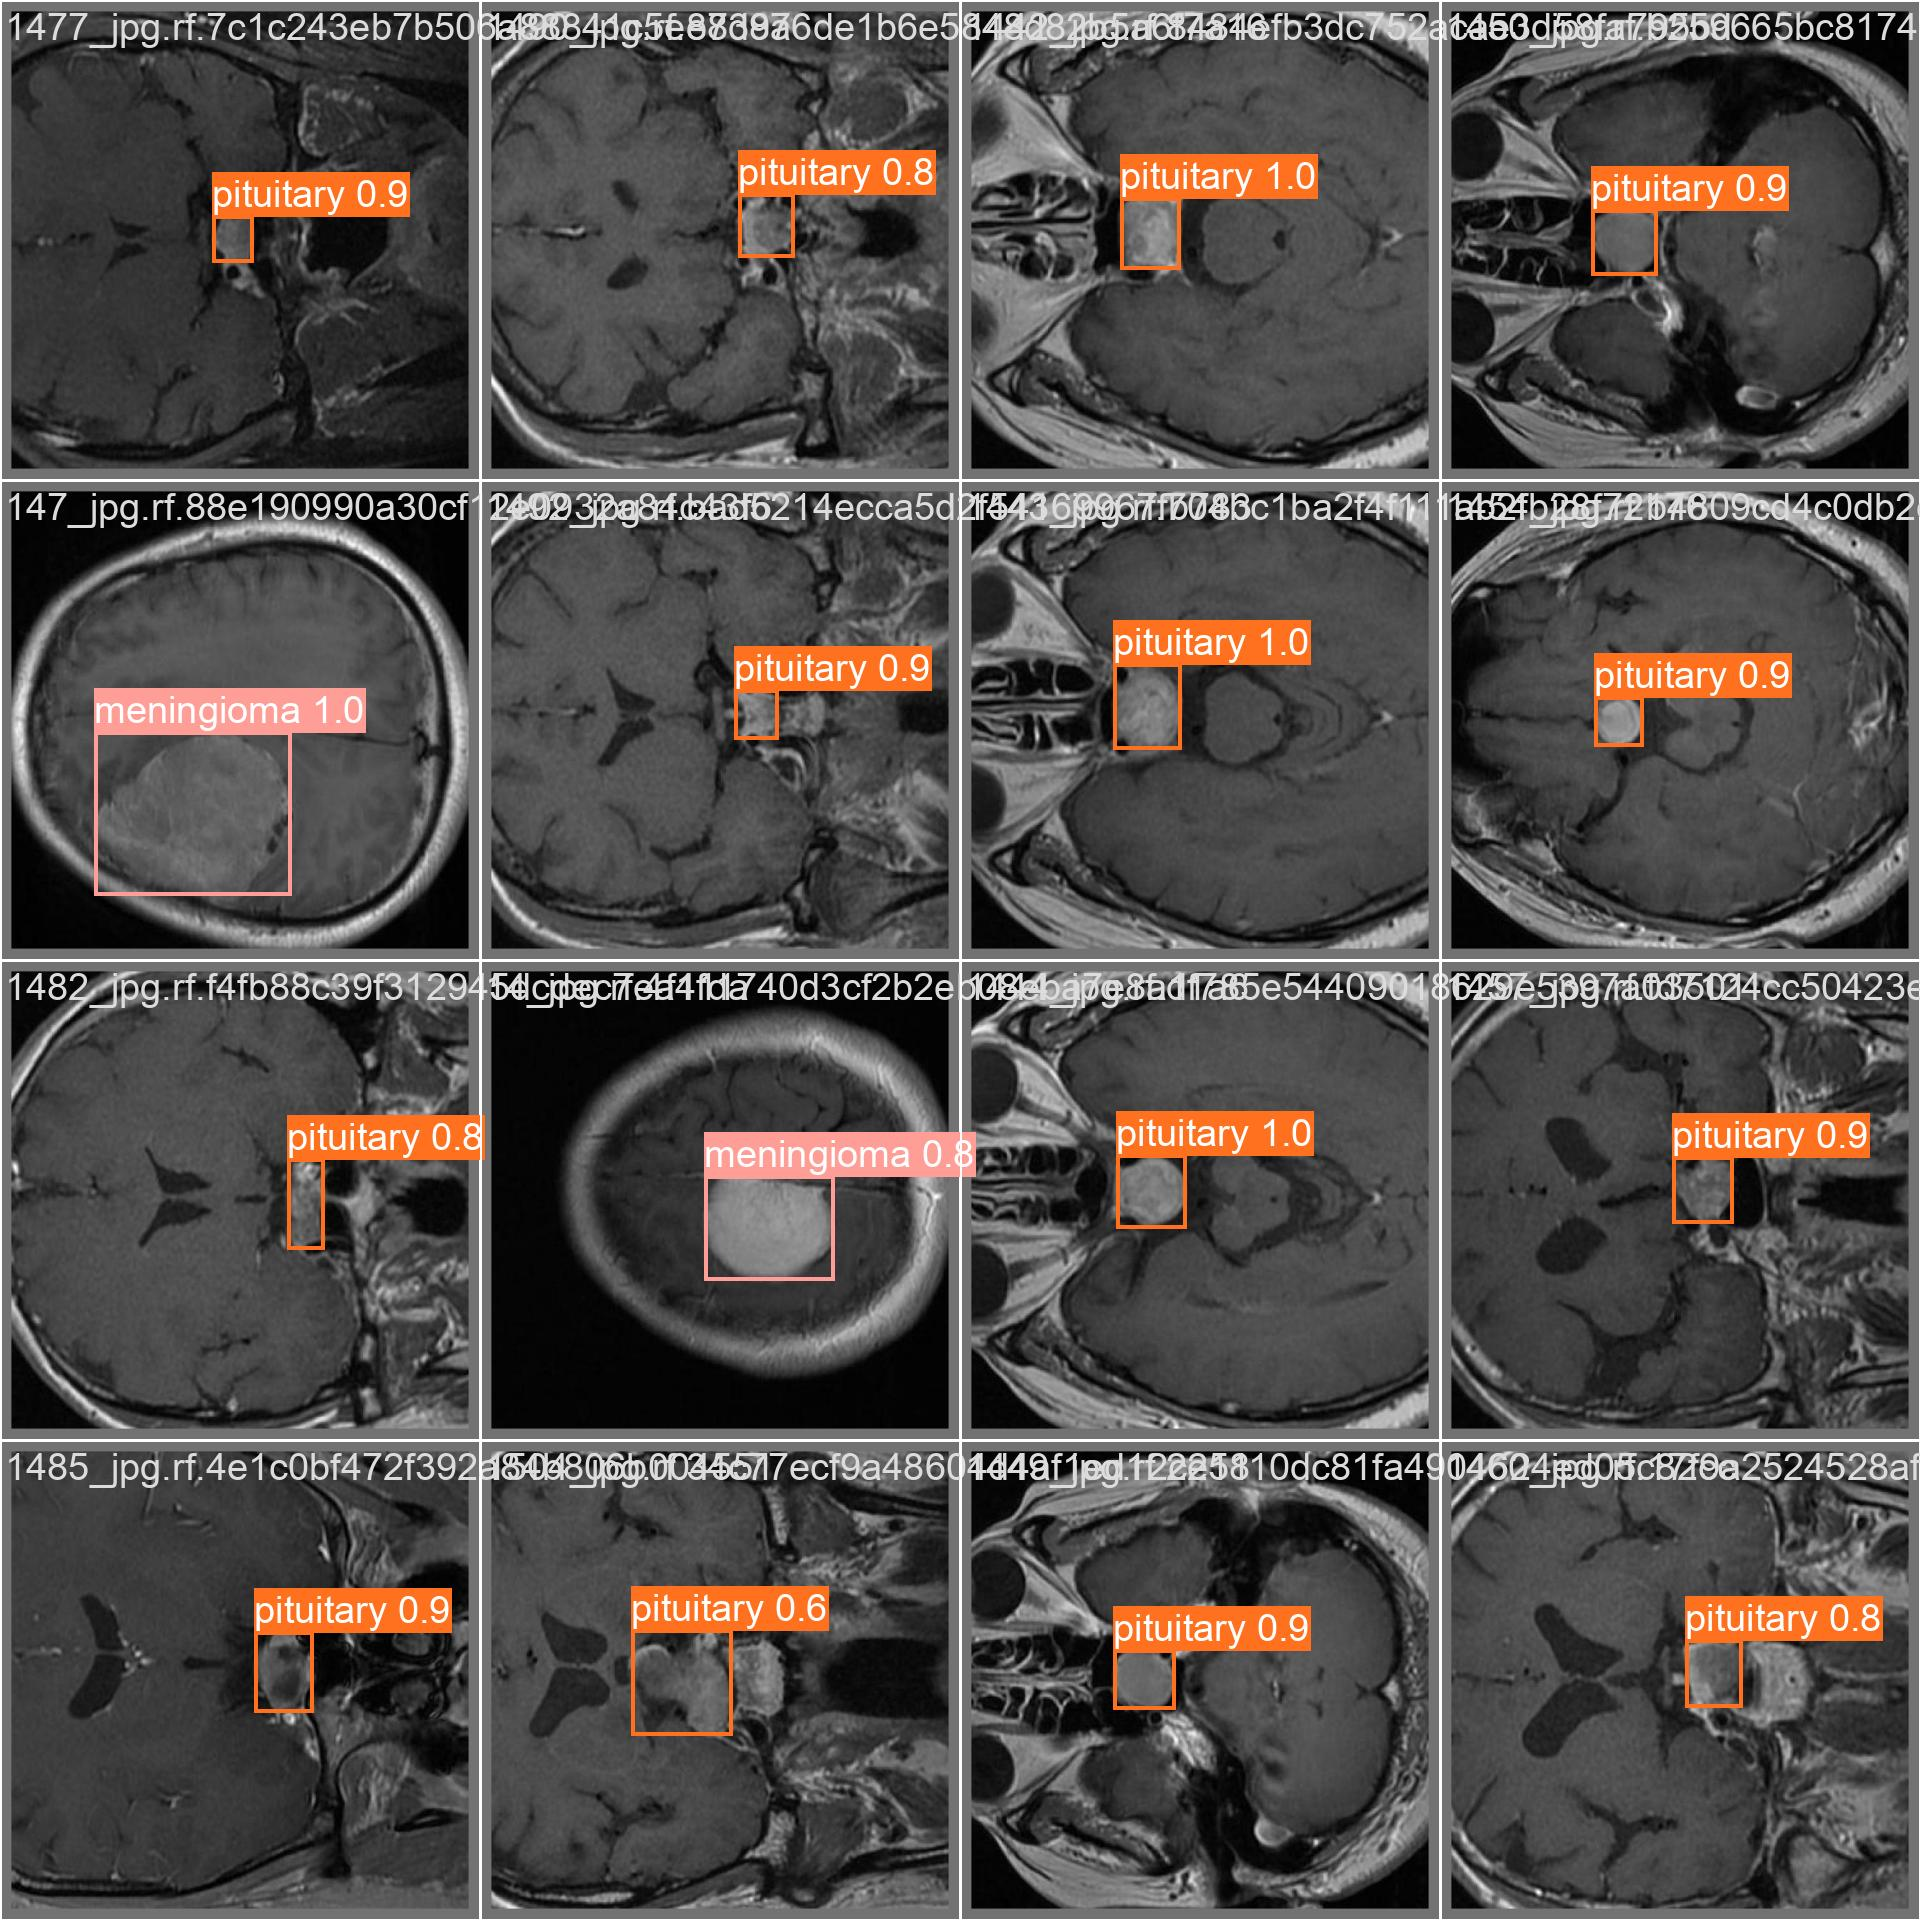

In [21]:

    # 7.4 Qualitative Results (Validation Batch Images)
    # These images show the model's actual predictions on a few batches of test images.
    # They are perfect for showing visual examples of your model's performance.
    print("\nQualitative Results (Predictions on Test Images)")
    validation_batch_images = glob.glob(os.path.join(results_dir, 'val_batch*_pred.jpg'))

    if validation_batch_images:
        for img_path in sorted(validation_batch_images)[:3]: # Display the first 3 batches
            print(f"\nDisplaying: {os.path.basename(img_path)}")
            display(Image(filename=img_path))
    else:
        print("No validation batch images found.")
